In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import scipy.integrate as integrate
import matplotlib.pyplot as plt

import gym
from gym import spaces

import random
import itertools as it
from joblib import Parallel, delayed
from toolz import memoize
from contracts import contract
from collections import namedtuple, defaultdict, deque, Counter

import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

from agents import Agent
from oldmouselab import OldMouselabEnv
from policies import FixedPlanPolicy, LiederPolicy
from evaluation import *
from distributions import cmax, smax, sample, expectation, Normal, PointMass, SampleDist, Normal, Categorical

In [2]:
def hd_dist(attributes):
    dist = [1,]*attributes
    dist[0] = np.random.randint(85,97)
    for i in range(1,attributes-1):
        dist[i] += np.random.randint(0,100-np.sum(dist))
    dist[-1] += 100-np.sum(dist)
    dist = np.around(np.array(dist)/100,decimals=2)
    np.random.shuffle(dist)
    return dist

def ld_dist(attributes):
    dist = [np.random.randint(10,40) for _ in range(attributes)]
    dist = np.around(np.array(dist)/sum(dist),decimals=2)
    np.random.shuffle(dist)
    return dist

In [3]:
gambles = 7
attributes = 4
mu_R_high_stakes = (9.99+0.01)/2
mu_R_low_stakes = (0.25+0.01)/2

sigma_R_high_stakes = 0.3*(9.99-0.01)
sigma_R_low_stakes = 0.3*(0.25-0.01)

high_stakes = Normal(mu_R_high_stakes, sigma_R_high_stakes)
low_stakes = Normal(mu_R_low_stakes, sigma_R_low_stakes)
reward = high_stakes
cost=.03

n_test = 100

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_test)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_test)]
test_envs_all = test_envs_hd+test_envs_ld 

term_action = test_envs_hd[0].term_action
nr_outcomes = attributes
nr_alternatives = gambles

In [40]:
agent = Agent()
def run_env(policy, env):
    agent.register(env)
    agent.register(policy)
    tr = agent.run_episode()
#     print(tr)
    return {'util': tr['return'], 'actions': tr['actions'],
            'observations': len(tr['actions']) - 1, 'ground_truth': env.ground_truth}

def action_coordinate(env, action):
    return (action//env.outcomes,action%env.outcomes)

def p_grid(env, actions):
    grid = np.zeros((env.gambles+1,env.outcomes))
    grid[0,:] = env.dist
    for i in range(len(actions[:-1])):
        gamble, outcome = action_coordinate(env,actions[i]) 
        grid[gamble+1, outcome] = i+1
    return grid

def expected_reward_of_termination(env,actions):
    env.reset()
    for a in actions:
        env.step(a)

    return env.expected_term_reward()

def characterize_strategy(policy,envs):
    operations = []
    nr_clicks = []
    probabilities = []
    returns = []
    observations = []
    grids = []
    p_grids = []
    p_outcomes = []
    p_ranks = []
    inspected_gambles = []
    inspected_outcomes = []
    nr_inspected_outcomes = []
    best_outcome_only = []
    expected_term_rewards = []
    
    for i in range(len(envs)):
        envs[i].reset()
        trace = run_env(policy, envs[i])
        returns = returns + [trace['util']]        
        operations = operations + [trace['actions']]
        nr_clicks = nr_clicks + [len(trace['actions'])-1]
        probabilities = probabilities + [envs[i].dist]
        p_grids = p_grids + [p_grid(envs[i],trace['actions'])]
        grids = grids + [envs[i].grid()]
        
        gambles = np.array([])
        outcomes = np.array([])
        observed_payoffs = np.array([])
        p_outcome = np.array([])
        p_rank = np.array([])
        array = -envs[i].dist
        temp = array.argsort()
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(len(array))+1
        #print(ranks)
        
        for a in trace['actions'][:-1]:
            gamble, outcome = action_coordinate(envs[i], a)
            gambles = np.append(gambles,[gamble])
            outcomes = np.append(outcomes,[outcome])
            p_outcome = np.append(p_outcome,[envs[i].dist[outcome]])
            p_rank = np.append(p_rank,[ranks[outcome]])
            observed_payoffs = np.append(observed_payoffs,trace['ground_truth'][a])
        
        p_ranks = p_ranks + [p_rank]
        

        best_outcome_only.append(np.all(np.unique(p_rank)==[1]))        
        observations = observations + [observed_payoffs]
        expected_term_rewards = expected_term_rewards  + [expected_reward_of_termination(envs[i],trace['actions'][:-1])] 
        p_outcomes = p_outcomes + [p_outcome]
        inspected_gambles = inspected_gambles + [gambles]
        inspected_outcomes= inspected_outcomes + [outcomes]
        nr_inspected_outcomes = nr_inspected_outcomes + [len(np.unique(outcomes))]
    
    return {'grids':grids,'expected_term_rewards': expected_term_rewards,'best_outcome_only': best_outcome_only,'nr_inspected_outcomes':nr_inspected_outcomes, 'p_ranks': p_ranks, 'p_outcomes': p_outcomes, 'inspected_gambles': inspected_gambles, 'inspected_outcomes': inspected_outcomes, 'p_grids': p_grids, 'returns': returns, 'observations': observations, 'operations':operations, 'nr_clicks': nr_clicks, 'probabilities': probabilities}
    

# High stakes, high dispersion

In [5]:
#bo_pol_theta = np.load('data/high_stakes_3cents.npy')
bo_pol_theta = np.load('data/high_stakes_0.5cents.npy')
bo_pol_high_stakes = LiederPolicy(list(bo_pol_theta))

In [6]:
hd_hs = characterize_strategy(bo_pol_high_stakes,test_envs_hd)

In [7]:
TTB_compatible = np.array([])

for i in range(n_test):
    TTB_compatible =  np.append(TTB_compatible, [hd_hs['nr_clicks'][i]==nr_alternatives and hd_hs['best_outcome_only'][i]])

print("On {}% of the high-dispersion trials the click squences of the high-stakes policy were consistent with TTB.".format(100*np.mean(TTB_compatible)))

On 77.0% of the high-dispersion trials the click squences of the high-stakes policy were consistent with TTB.


In [49]:
print("The high-stakes policy inspected more than 7 cells in {}% of the trials.".format(100*np.mean(np.array(hd_hs['nr_clicks'])>7)))
print("The high-stakes policy inspected more than 1 outcome in {}% of the high-dispersion trials.".format(100*np.mean(np.array(hd_hs['nr_inspected_outcomes'])>1)))

The high-stakes policy inspected more than 7 cells in 8.0% of the trials.
The high-stakes policy inspected more than 1 outcome in 8.0% of the high-dispersion trials.


True
In  1e+02% of the high-dispersion problems, the high-stakes policy considered only the most probably outcome.

In the high-dispersion environment the BO policy made between 2 and 9 clicks. The average number of clicks was 6.6.

 Example: 
[[ 0.85  0.02  0.05  0.08]
 [ 1.    0.    0.    0.  ]
 [ 3.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 2.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]]
[[11.102207463038466 Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99)]
 [5.4714014177404868 Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99)]
 [Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99)]
 [7.0668110977345941 Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99)]
 [Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99)]
 [Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99)]
 [Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99) Norm(5.00, 2.99)]]


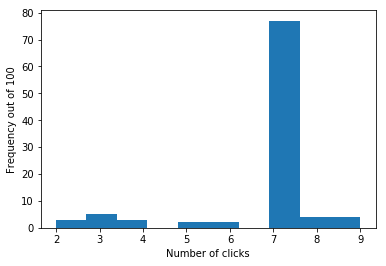

In [17]:
print(np.all(hd_hs['best_outcome_only']))

print("In {:6.3}% of the high-dispersion problems, the high-stakes policy considered only the most probably outcome.".format(100*np.mean(hd_hs['best_outcome_only'])))
print("")
avg_nr_clicks_hd_hs=np.mean(hd_hs['nr_clicks'])
min_nr_clicks_hd_hs=np.min(hd_hs['nr_clicks'])
max_nr_clicks_hd_hs=np.max(hd_hs['nr_clicks'])

print('In the high-dispersion environment the BO policy made between {} and {} clicks. The average number of clicks was {:3.2}.'.format(min_nr_clicks_hd_hs,max_nr_clicks_hd_hs,avg_nr_clicks_hd_hs))

plt.figure()
plt.hist(hd_hs['nr_clicks'])
plt.xlabel('Number of clicks')
plt.ylabel('Frequency out of 100')

print("\n Example: ")
print(hd_hs['p_grids'][1])
print(test_envs_hd[1].grid())

Aspiration level after 2 clicks: 11.097677380787303
Aspiration level after 3 clicks: 10.186876343582696
Aspiration level after 4 clicks: 10.409979723520394
Aspiration level after 5 clicks: 9.920667618186249
Aspiration level after 6 clicks: 9.84939779370581
Aspiration level after 7 clicks: 5.966988799391908


Text(0.5,0,'Number unexplored alternatives')

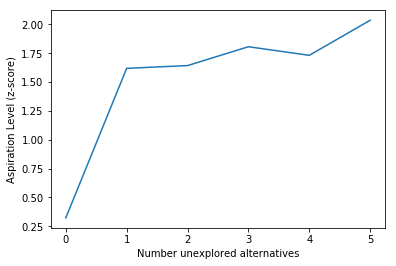

In [9]:
click_nrs = np.unique(hd_hs['nr_clicks'])
nr_clicks = np.array(hd_hs['nr_clicks'])
expected_returns = np.array(hd_hs['expected_term_rewards'])

aspiration_levels = dict()

for n in click_nrs[:-2]:
    print("Aspiration level after {} clicks: {}".format(n,np.min(expected_returns[nr_clicks==n])))
    aspiration_levels[n] = (np.min(expected_returns[nr_clicks==n])-mu_R_high_stakes)/sigma_R_high_stakes

plt.figure()
plt.plot(nr_alternatives-np.array([float(val) for val in aspiration_levels.keys()]),aspiration_levels.values())
plt.ylabel('Aspiration Level (z-score)')
plt.xlabel('Number unexplored alternatives')

#hd_hs['observations'][2]

# High stakes, low dispersion

In [50]:
bo_pol_theta = np.load('data/high_stakes_3cents.npy')
bo_pol_high_stakes = LiederPolicy(list(bo_pol_theta))

In [51]:
ld_hs = characterize_strategy(bo_pol_high_stakes,test_envs_ld)

In [52]:
avg_nr_clicks_ld_hs=np.mean(hd_hs['nr_clicks'])
min_nr_clicks_ld_hs=np.min(hd_hs['nr_clicks'])
max_nr_clicks_ld_hs=np.max(hd_hs['nr_clicks'])

print('In the low-dispersion environment the BO policy made between {} and {} clicks. The average number of clicks was {:4.2}'.format(min_nr_clicks_ld_hs,max_nr_clicks_ld_hs,avg_nr_clicks_ld_hs))

In the low-dispersion environment the BO policy made between 3.0 and 18.0 clicks. The average number of clicks was  8.9


# Low stakes, high dispersion

In [53]:
bo_pol_theta = np.load('data/low_stakes_3cents.npy')
bo_pol_low_stakes = LiederPolicy(list(bo_pol_theta))

FileNotFoundError: [Errno 2] No such file or directory: 'data/low_stakes_3cents.npy'

In [ ]:
hd_ls = characterize_strategy(bo_pol_low_stakes,test_envs_hd)

In [ ]:
avg_nr_clicks_hd_ls=np.mean(hd_ls['nr_clicks'])
min_nr_clicks_hd_ls=np.min(hd_ls['nr_clicks'])
max_nr_clicks_hd_ls=np.max(hd_ls['nr_clicks'])

print('In the high-dispersion environment the low-stakes policy made between {} and {} clicks. The average number of clicks was {:4.2}'.format(min_nr_clicks_hd_ls,max_nr_clicks_hd_ls,avg_nr_clicks_hd_ls))

# Low stakes, low dispersion

In [ ]:
bo_pol_theta = np.load('data/low_stakes_3cents.npy')
bo_pol_low_stakes = LiederPolicy(list(bo_pol_theta))

In [ ]:
ld_ls = characterize_strategy(bo_pol_low_stakes,test_envs_ld)

In [ ]:
avg_nr_clicks_ld_ls=np.mean(ld_ls['nr_clicks'])
min_nr_clicks_ld_ls=np.min(ld_ls['nr_clicks'])
max_nr_clicks_ld_ls=np.max(ld_ls['nr_clicks'])

print('In the low-dispersion environment the low-stakes policy made between {} and {} clicks. The average number of clicks was {:4.2}'.format(min_nr_clicks_ld_ls,max_nr_clicks_ld_ls,avg_nr_clicks_ld_ls))